<a href="https://colab.research.google.com/github/moisesortega93/MCME-AI/blob/main/Recommenders_and_clustering_ESP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PEC1: Recomendadores y agrupación:**

Este archivo de cuaderno interactivo de jupyter le ayudará a comenzar con las operaciones básicas necesarias para resolver los ejercicios del PEC. Utilice este archivo para proporcionar una solución a los ejercicios (tanto el código como los comentarios escritos). Agregue tantas celdas de código y de texto como necesite para resolver todos los ejercicios. Asegúrate de que el archivo se puede ejecutar completamente antes de cargarlo para su entrega.

### Instalar las librerías suprise en google colab:

In [50]:
!pip install scikit-surprise

import surprise

## **Ejercicio 1: Manipulación de datos con surprise and Pandas:**

Este primer ejercicio es para familiarizarse con el conjunto de datos de Jester y cómo realizar la manipulación básica de datos usando Pandas.


a) Cargar la base de datos Jester desde el surprise dataset

In [43]:
from surprise import Dataset

data = Dataset.load_builtin('jester')


Convertir los datos a un Pandas dataframe

In [ ]:
print(data.__dict__())

TypeError: ignored

In [42]:
import pandas as pd
df = pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id', 'item_id', 'rating', 'timestamp'])
print(df.shape)

(1761439, 4)


Realizar inspección y manipulación básica de los datos:

Enumere las 10 primeras entradas del conjunto de datos:


In [ ]:
df.head(10) 

,user_id,item_id,rating,timestamp
0,1,5,0.219,None
1,1,7,-9.281,None
2,1,8,-9.281,None
3,1,13,-6.781,None
4,1,15,0.875,None
5,1,16,-9.656,None
6,1,17,-9.031,None
7,1,18,-7.469,None
8,1,19,-8.719,None
9,1,20,-9.156,None


¿Cuántas entradas hay en el conjunto de datos?

In [ ]:
df.shape[0] # 0: number of rows, 1: number of columns/variables
len(df)
df.__len__()

1761439

¿Cuántos usuarios y chistes hay en la base de datos?

In [ ]:
print('Number of users:')
df["user_id"].nunique() # number of users
len(df.groupby(['user_id']))

Number of users:


59132

In [41]:
print('Number of items:')
df["item_id"].nunique() # number of items
len(df.groupby(['user_id']))

Number of items:


59132

¿Cuál es la calificación del usuario con user_id = 1 de la chiste con item_id = 5?


In [40]:
df.loc[(df["user_id"]=='1') & (df["item_id"]=='5')]
df.loc[(df["user_id"]=='1') & (df["item_id"]=='5'),"rating"].values[0]
df.iloc[[i for i, x in enumerate((df["user_id"]=='1') & (df["item_id"]=='5')) if x], 2]
name=1;
print("La califación del user_id:", name, " es ", df.loc[(df["user_id"]=='1') & (df["item_id"]=='5'),"rating"].values[0], sep='')

La califación del user_id:1 es 0.219


b) Filtrar el conjunto de datos:

Filtre la base de datos manteniendo solo los elementos que hayan calificado al menos min_item_ratings usuarios y usuarios que hayan calificado al menos los elementos min_user_ratings:

In [44]:
min_item_ratings = 200
filter_items = df['item_id'].value_counts() > min_item_ratings
filter_items = filter_items[filter_items].index.tolist()

min_user_ratings = 130
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_small = df[(df['item_id'].isin(filter_items)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_small.shape))

The original data frame shape:	(1761439, 4)
The new data frame shape:	(1325, 4)


Convierta el marco de datos de nuevo a una variable surprise utilizando las funciones reader y load_from_df:

https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset

In [46]:
from surprise import Reader 
reader = Reader(rating_scale=(-10, 10))
data_small = Dataset.load_from_df(df_small[['user_id', 'item_id', 'rating']], reader)

Responde las siguientes preguntas:

- ¿Cuántos usuarios y elementos hay en el conjunto de datos reducido?


In [31]:
df_small.__len__()

df_small = pd.DataFrame(data_small.__dict__['raw_ratings'], columns=['user_id', 'item_id', 'rating', 'timestamp'])
print("El conjunto de datos reducido df_small contiene {} elementos".format(df_small.shape[0]))
len(df_small)

El conjunto de datos reducido df_small contiene 1325 elementos


1325

- Proporcione una breve descripción de las principales características del conjunto de datos.



In [ ]:
df_small.head()

#df_small.drop(['timestamp'], axis=1)
df_small.describe()
#df_small.info()



,rating
count,1325.000000
mean,2.346844
std,5.032869
min,-9.844000
25%,-1.438000
50%,3.500000
75%,6.281000
max,9.969000


c) Proporcione una representación gráfica de la distribución del número de usuarios con un determinado número de valoraciones. ¿Cuáles son las principales conclusiones que se pueden sacar de este gráfico ?


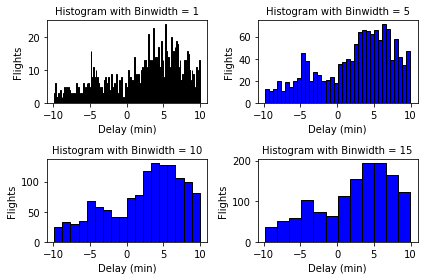

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

for i, binwidth in enumerate([1, 5, 10, 15]):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(df_small['rating'], bins = int(180/binwidth),
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 10)
    ax.set_xlabel('Delay (min)', size = 10)
    ax.set_ylabel('Flights', size= 10)

plt.tight_layout()
plt.show()

## **Ejercicio 2: Diferentes formas de diseñar un sistema de recomendación**
En este ejercicio estamos explorando diferentes formas de diseñar / entrenar un sistema de recomendación. A menos que se indique lo contrario, este ejercicio se realizará con el conjunto de datos reducido obtenido en el ejercicio anterior.



a) Ajuste un recomendador de descomposición de valores singulares utilizando como datos de entrenamiento todo el conjunto de datos reducido. ¿Cuál es la tasa prevista de user_id = 46 del chiste con item_id = 44 ?. ¿Cuál es la discrepancia entre la qualificació prevista y la real? Evalúe el rendimiento de este enfoque utilizando RMSE, MAE y MSE como métricas de precisión.


In [54]:
# Build an algorithm, and train it.
mSVD = surprise.SVD()
mSVD.fit()
mSVD.fit(data_small)
uid = str(46)  # raw user id (as in the ratings file). They are **strings**!
iid = str(44)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
#pred = algo.predict(uid, iid, r_ui=4, verbose=True)


AttributeError: ignored

b) Ajuste el mismo recomendador pero ahora dividiendo los datos en subconjuntos de entrenamiento y prueba en tres proporciones diferentes (entrenamiento / prueba): 90/10, 75/25 y 10/90. Compare el RMSE, MAE y MSE promedio cuando utilice diferentes fracciones para los subconjuntos de entrenamiento y prueba. ¿Qué proporción produce mejores resultados de predicción? Justifica tu respuesta.


In [17]:
from surprise import model_selection
from surprise import SVD

for size in [0.1, 0.25,0.9]:

  trainset, testset = model_selection.train_test_split(data, test_size=size)

  # We'll use the famous SVD algorithm.
  mSVD = SVD()

  # Train the algorithm on the trainset, and predict ratings for the testset
  mSVD.fit(trainset)
  predictions = mSVD.test(testset)

  # Then compute RMSE
  accuracy.rmse(predictions)
  accuracy.mse(predictions)
  accuracy.mae(predictions)

NameError: ignored

c) Ajuste y evalúe ahora el recomendador de SVD utilizando un procedimiento de validación cruzada de 5 veces (cv = 5). Compare los resultados medios con el rendimiento obtenido en los apartados anteriores. Explique las diferencias de forma razonada.


d) Use una validación cruzada de 5 veces para comparar el desempeño de las versiones sesgadas e imparciales del recomendador de SVD descrito en https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization. SVD. ¿Qué método proporciona una mejor precisión de predicción? ¿Por qué?


e) Confirme la comparación entre los algoritmos SVD sesgados e insesgados realizando una validación cruzada de búsqueda de cuadrícula https://surprise.readthedocs.io/en/stable/getting_started.html#tune-algorithm-parameters-with-gridsearchcv

In [ ]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

## **Ejercicio 3: Comparar algoritmos de agrupamiento con datos sintéticos**
En esta sección, comparará dos de los algoritmos de agrupación en clúster más comunes que utilizan datos generados sintéticamente.



a) Utilice la función make_blobs de la biblioteca sklearn para generar 1500 observaciones bidimensionales distribuidas equitativamente en tres grupos centrados en las posiciones (0,0), (4,4) y (6,6). La descripción de la función se puede encontrar aquí:
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html


b) Agrupar los datos usando un algoritmo de k-medias con k = 3 y un método de agrupamiento jerárquico / aglomerativo con tres grupos. Represente gráficamente los resultados con diagramas de dispersión usando diferentes colores para cada uno de los grupos identificados por los dos métodos. Compare los resultados de la agrupación en clústeres. ¿Qué método es mejor cuando el verdadero centroide de los grupos se acerca?


c) Repita las tareas de las dos secciones anteriores, pero ahora genere las observaciones con las siguientes varianzas desiguales: 1, 2.5 y 0.5 respectivamente. Comente los resultados.